Epoch 1/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1753 - val_loss: 0.0499
Epoch 2/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0498 - val_loss: 0.0497
Epoch 3/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0495 - val_loss: 0.0497
Epoch 4/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0495 - val_loss: 0.0496
Epoch 5/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0494 - val_loss: 0.0495
Epoch 6/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0496 - val_loss: 0.0494
Epoch 7/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0496 - val_loss: 0.0494
Epoch 8/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0496 - val_loss: 0.0494
Epoch 9/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0493 - val_loss: 0.0494
Epoch 10/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0496 - val_loss: 0.0495
Epoch 11/50
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0494 - val_loss: 0.0494
Epoch 12/50
1781/1781 ━━━━━━━━

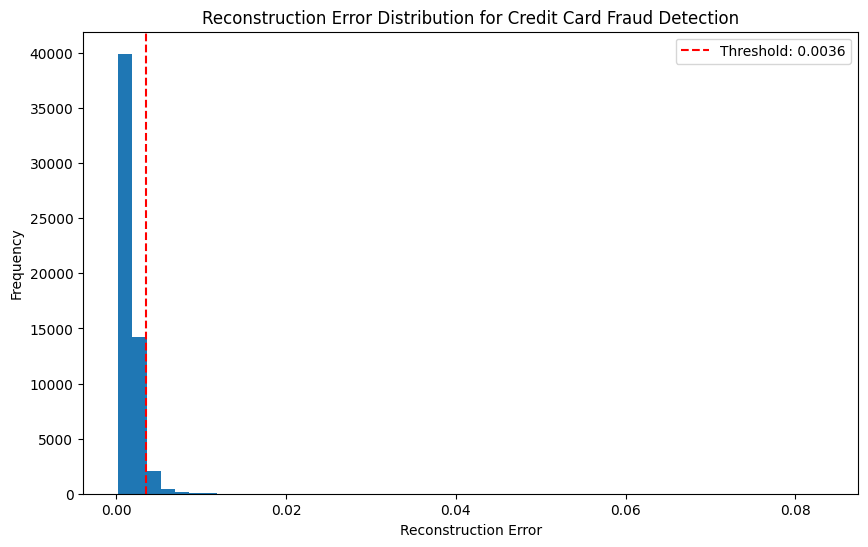

Precision: 0.0274
Recall: 0.7959
F1 Score: 0.0529


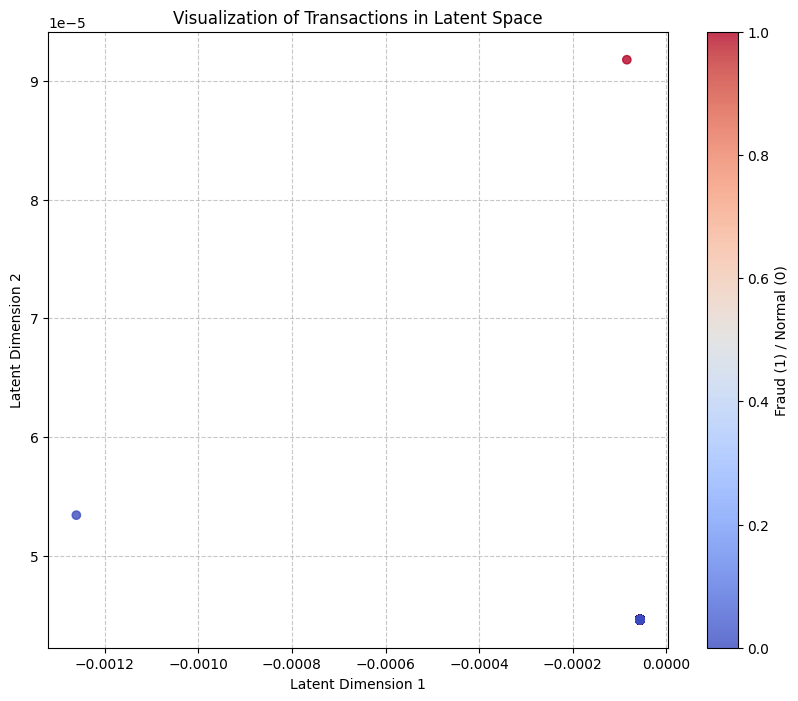

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Data Collection and Preprocessing
# Load the credit card fraud detection dataset from Kaggle
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Feature engineering: Drop 'Time' and 'Class' columns
features = data.drop(columns=['Class', 'Time'])

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Split the dataset into train and test sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

# Step 2: Build the VAE Model
latent_dim = 2  # Latent space dimension

# Define the VAE model using Keras functional API
class VAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder_layers = [
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
        ]
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        
        # Decoder
        self.decoder_layers = [
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ]
    
    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def decode(self, z):
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
        return x
    
    def call(self, inputs):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        
        return reconstructed

# Create and compile the VAE model
input_dim = X_train.shape[1]
vae = VAE(input_dim, latent_dim)

# Define the loss function (reconstruction loss) using MSE
def vae_loss(y_true, y_pred):
    # Calculate the mean squared error manually since the function name is different in TF 2.x
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    # Scale by input dimension
    reconstruction_loss = input_dim * mse
    return tf.reduce_mean(reconstruction_loss)

# Compile the model
vae.compile(optimizer='adam', loss=vae_loss)

# Step 3: Train the VAE model
history = vae.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, X_test)
)

# Step 4: Use the trained model for fraud detection
reconstructed_test = vae.predict(X_test)

# Calculate reconstruction error for each sample
reconstruction_error = np.mean(np.square(reconstructed_test - X_test), axis=1)

# Step 5: Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)  # Top 5% are considered anomalies
fraudulent_transactions = reconstruction_error > threshold

# Step 6: Evaluate results
print(f"Number of fraudulent transactions detected: {np.sum(fraudulent_transactions)}")

# Step 7: Visualize results
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('Reconstruction Error Distribution for Credit Card Fraud Detection')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# If the original dataset has fraud labels, evaluate the model's performance
# Note: This code assumes X_test indices correspond to the original dataset,
# which is not correct with train_test_split. Fix included below.
try:
    # Get the actual test indices for proper evaluation
    _, X_test_idx = train_test_split(np.arange(len(scaled_features)), test_size=0.2, random_state=42)
    test_labels = data.iloc[X_test_idx]['Class'].values
    
    # Calculate confusion matrix elements
    true_positives = np.sum((test_labels == 1) & fraudulent_transactions)
    false_positives = np.sum((test_labels == 0) & fraudulent_transactions)
    true_negatives = np.sum((test_labels == 0) & ~fraudulent_transactions)
    false_negatives = np.sum((test_labels == 1) & ~fraudulent_transactions)
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    # Visualize in 2D latent space
    # Get latent representations
    test_inputs = tf.convert_to_tensor(X_test, dtype=tf.float32)
    z_mean, z_log_var = vae.encode(test_inputs)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=test_labels, cmap='coolwarm', alpha=0.8)
    plt.colorbar(scatter, label='Fraud (1) / Normal (0)')
    plt.title('Visualization of Transactions in Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
except Exception as e:
    print(f"Unable to evaluate with original labels: {e}")
    
    # Still try to visualize the latent space without labels
    test_inputs = tf.convert_to_tensor(X_test, dtype=tf.float32)
    z_mean, z_log_var = vae.encode(test_inputs)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.8)
    plt.title('Visualization of Transactions in Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()